In [34]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from DDUN.SUNET.unet import Unet
from DDUN.SUNET.markovddpm import MarkovDDPM
from DDUN.SUNET.embedding import SinsuoidalPostionalEmbedding
from DDUN.SUNET.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# * Initialization
N_STEPS = 100
BATCH_SIZE = 16  # 1024
TIME_EMB_DIM = 100
START = 0.0001
END = 0.02
lr = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = 'cpu'

# * Data
transform_data = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x - 0.5) * 2.0)]
)

reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: (t + 1) / 2),
     #transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

loader = DataLoader(
    datasets.FashionMNIST("data", train=True, download=True, transform=transform_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [36]:
#########################
#* Training
unet  = Unet(N_STEPS, TIME_EMB_DIM, DEVICE)#.to(DEVICE)

Markovddpm = MarkovDDPM(unet, N_STEPS, START, END, DEVICE).to(DEVICE)
mse = nn.MSELoss()  # * try L1 loss
optimizer = Adam(Markovddpm.parameters(), lr=lr)
n_step = Markovddpm.n_steps
EPOCHS = 100
BEST_LOSS = float("inf")

In [37]:
Markovddpm.load_state_dict(torch.load("models/best_ddpm.pt"))
optimizer.load_state_dict(torch.load("models/optimizer.pt"))

In [38]:
noise = torch.randn(BATCH_SIZE, 1, 28, 28, device=DEVICE)
t = torch.randint(0, n_step, (BATCH_SIZE,), device=DEVICE)

In [39]:
diffused = Markovddpm.backward(
    x=torch.randn(1, 1, 28, 28, device=DEVICE),
    t=torch.randint(0, n_step, (1,), device=DEVICE),
)

In [40]:
for step, (x, _) in enumerate(loader):
    x = x.to(DEVICE)
    n  = len(x)
    
    noise = torch.randn_like(x).to(DEVICE)
    time = torch.randint(0, n_step, (n,), device=DEVICE).long()
    
    #* noisy img
    noisy_img = Markovddpm.forward(x, time, noise)
    
    #* eta hat
    eta_hat = Markovddpm.backward(noisy_img, time)
    break

print(x.shape), print(noise.shape), print(time.shape), print(noisy_img.shape), print(eta_hat.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])


(None, None, None, None, None)

In [41]:
import matplotlib.pyplot as plt
def plot_img_from_tensor(x):
    x = x.permute(1, 2, 0)
    x = x.detach().cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(x, cmap="gray")
    plt.axis("off")
    plt.show()

In [42]:
noise = torch.randn(1, 1, 28, 28, device=DEVICE)
for idx, t in enumerate(list(range(N_STEPS))[::-1]):
    time_tensor  = torch.tensor([t], device=DEVICE).repeat(noise.shape[0], 1)
    eta_hat = Markovddpm.backward(noise, time_tensor)
    
    alpha_t = Markovddpm.alphas[t]
    # alphas_bar_t = Markovddpm.alphas_bar[t]
    





In [67]:
sampled = Markovddpm.p_sample(
    x = torch.randn(1, 1, 28, 28, device=DEVICE),
    t = torch.randint(0, n_step, (1,), device=DEVICE),
)

sampled.is_cuda



False

In [70]:
Markovddpm(
    x0 = torch.randn(1, 1, 28, 28, device=DEVICE),
    t = torch.randint(0, n_step, (1,), device=DEVICE),
    noise= None,

).shape

torch.Size([1, 1, 28, 28])

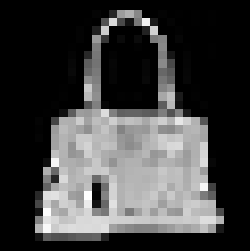

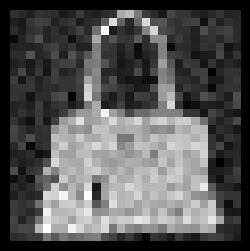

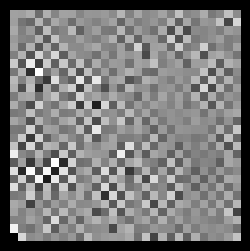

In [71]:
plot_img_from_tensor(x[0])
plot_img_from_tensor(noisy_img[0])
plot_img_from_tensor(eta_hat[0])


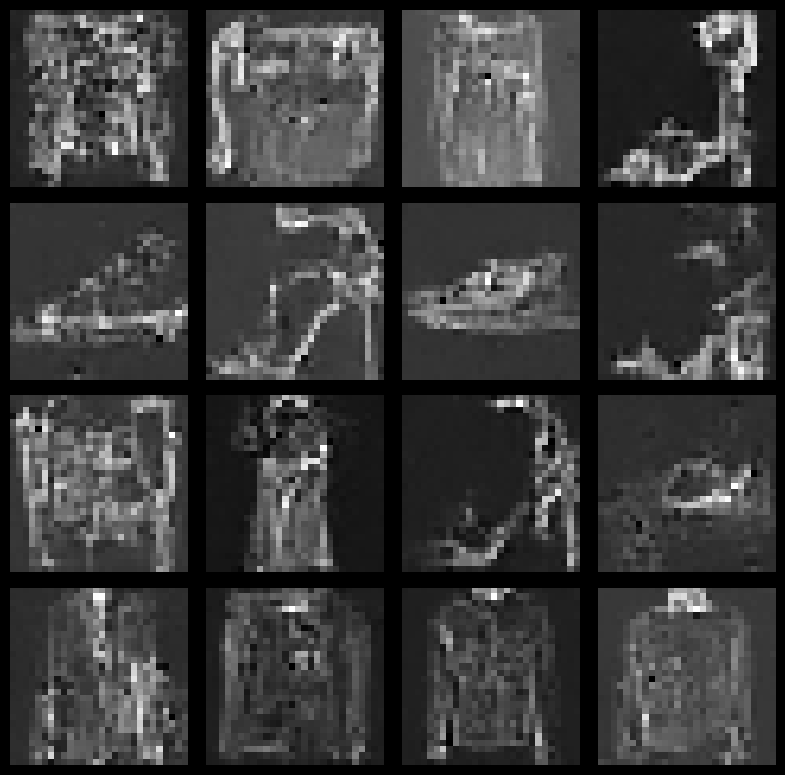

In [72]:
model_path = r'models\best_ddpm.pt'
Markovddpm.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
#optimizer.load_state_dict(torch.load(optimizer_path, map_location=torch.device(DEVICE)))

show_images(
    generate_new_images(
        Markovddpm, n_sample=16, device=DEVICE, gif_name="best_model_sampling.gif"
    )
)

In [91]:
diffused = Markovddpm.generate(x_shape=(16, 1, 28, 28))

In [92]:
diffused.shape[0]

16

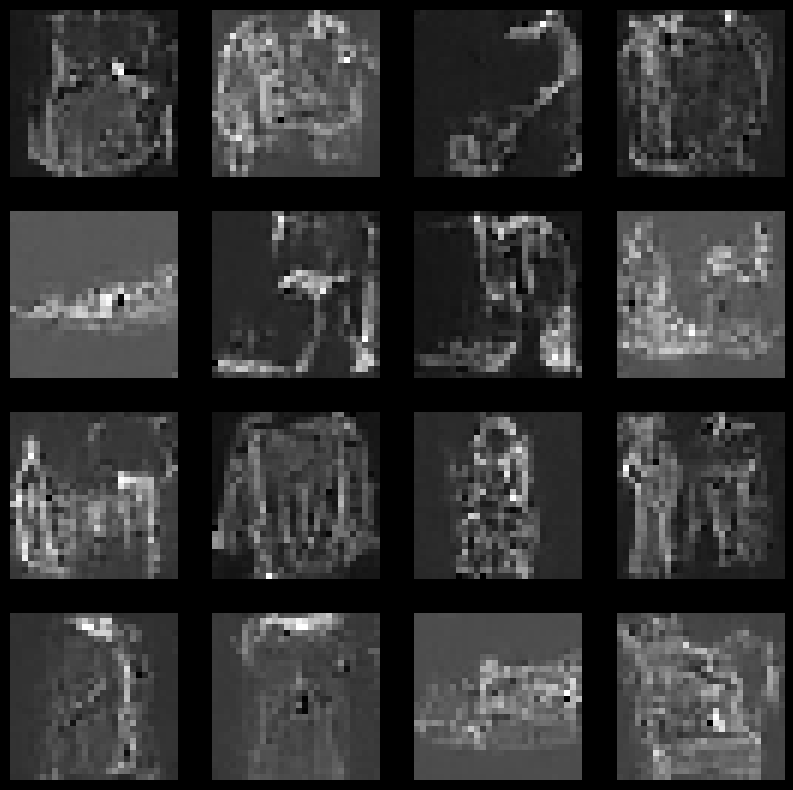

In [93]:
plt.figure(figsize=(10, 10))
for i in range(diffused.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(diffused[i], cmap="gray")
    plt.axis("off")

    
    

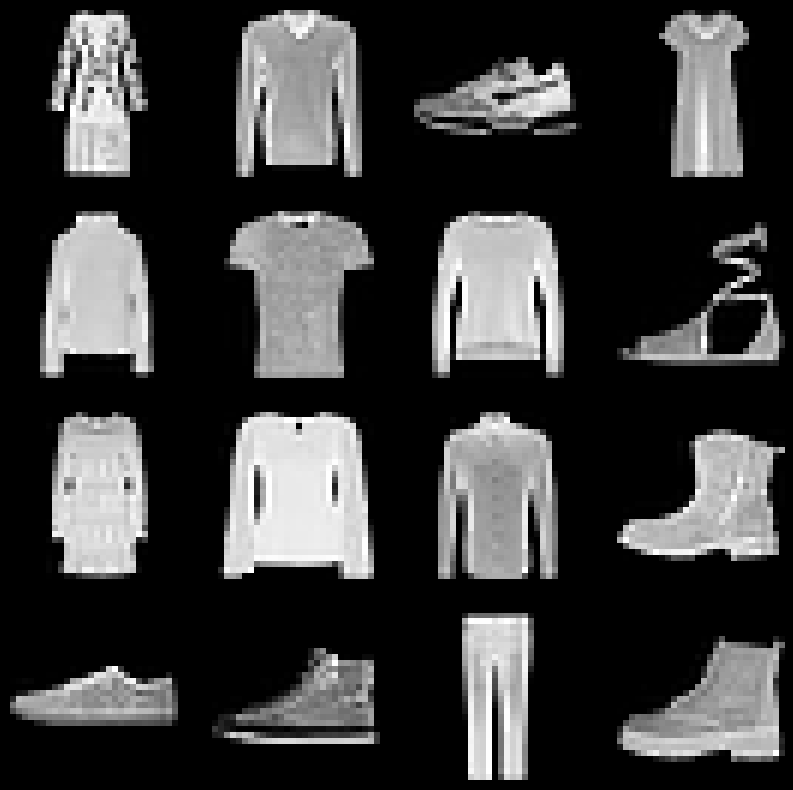

In [ ]:
x, y = next(iter(loader))

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[i, 0], cmap="gray")
    plt.axis("off")
